In [1]:
import numpy as np
W = np.arange(21).reshape(7, 3)
W

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11],
       [12, 13, 14],
       [15, 16, 17],
       [18, 19, 20]])

In [2]:
W[2]

array([6, 7, 8])

In [3]:
W[5]

array([15, 16, 17])

In [4]:
idx = np.array([1, 0, 3, 0])
W[idx]

array([[ 3,  4,  5],
       [ 0,  1,  2],
       [ 9, 10, 11],
       [ 0,  1,  2]])

In [5]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None
    
    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out
    
    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

In [7]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None
    
    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)
        
        self.cache = (h, target_W)
        return out
    
    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

In [8]:
import numpy as np
np.random.choice(10)

9

In [9]:
np.random.choice(10)

5

In [10]:
words = ['you', 'say', 'goodbye', 'I', 'hello', '.']
np.random.choice(words)

np.str_('say')

In [11]:
np.random.choice(words, size=5)

array(['I', 'you', 'you', 'you', 'you'], dtype='<U7')

In [12]:
np.random.choice(words, size=5, replace=False)

array(['.', 'you', 'hello', 'goodbye', 'I'], dtype='<U7')

In [13]:
p = [0.5, 0.1, 0.05, 0.2, 0.05, 0.1]
np.random.choice(words, p=p)

np.str_('.')

In [14]:
import collections

class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]
        negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),replace=True, p=self.word_p)

        return negative_sample

In [15]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
negative_sample

array([[4, 2],
       [2, 3],
       [4, 4]])

In [16]:
from common.layers import SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)]
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)
        
        return loss
    
    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)
        
        return dh

In [19]:
import sys
sys.path.append('..')
from common.layers import Embedding

class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 0[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 1[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 1[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 2[s] | loss 3.94
| epoch 1 |  iter 121 / 9295 | time 2[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 3[s] | loss 3.64
| epoch 1 |  iter 161 / 9295 | time 3[s] | loss 3.49
| epoch 1 |  iter 181 / 9295 | time 3[s] | loss 3.37
| epoch 1 |  iter 201 / 9295 | time 4[s] | loss 3.26
| epoch 1 |  iter 221 / 9295 | time 4[s] | loss 3.17
| epoch 1 |  iter 241 / 9295 | time 5[s] | loss 3.09
| epoch 1 |  iter 261 / 9295 | time 5[s] | loss 3.02
| epoch 1 |  iter 281 / 9295 | time 6[s] | loss 2.97
| epoch 1 |  iter 301 / 9295 | time 6[s] | loss 2.94
| epoch 1 |  iter 321 / 9295 | time 6[s] | loss 2.87
| epoch 1 |  iter 341 / 9295 | time 7[s] | loss 2.85
| epoch 1 |  iter 361 / 9295 | time 7[s] | loss 2.85

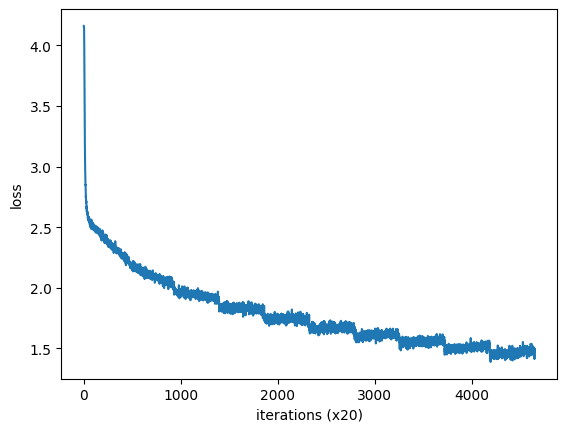

In [20]:
import sys
sys.path.append('..')
from common import config
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target
from nndataset import ptb

window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocal_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)
model = CBOW(vocal_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [21]:
import sys
sys.path.append('..')
from common.util import most_similar
import pickle

pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)



[query] you
 we: 0.74169921875
 i: 0.70703125
 your: 0.61181640625
 they: 0.58740234375
 anything: 0.580078125

[query] year
 month: 0.85205078125
 summer: 0.75927734375
 week: 0.75927734375
 spring: 0.732421875
 decade: 0.693359375

[query] car
 window: 0.6142578125
 auto: 0.6103515625
 luxury: 0.591796875
 truck: 0.57568359375
 cars: 0.5615234375

[query] toyota
 tires: 0.6298828125
 nissan: 0.6279296875
 nec: 0.62646484375
 packaging: 0.62109375
 chevrolet: 0.6171875


In [22]:
from common.util import analogy

analogy('man', 'king', 'woman', word_to_id, id_to_word, word_vecs, top=5)


[analogy] man:king = woman:?
 horse: 4.4140625
 wife: 4.11328125
 artist: 4.0625
 son: 3.72265625
 lexington: 3.71484375


In [23]:
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs, top=5)


[analogy] king:man = queen:?
 a.m: 5.49609375
 woman: 5.1484375
 father: 4.8203125
 husband: 4.68359375
 toxin: 4.64453125


In [24]:
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs, top=5)


[analogy] take:took = go:?
 eurodollars: 4.46875
 're: 4.390625
 went: 4.140625
 goes: 3.916015625
 a.m: 3.90625
